In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [300]:
# module import 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVC

In [169]:
# load data
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

# EDA

### column description
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.<br>
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
Destination - The planet the passenger will be debarking to.<br>
Age - The age of the passenger.<br>
VIP - Whether the passenger has paid for special VIP service during the voyage.<br>
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
Name - The first and last names of the passenger.<br>
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br>**

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
print("train len :", len(train))
print("test len :", len(test))
print("Transported 비율:\n", train['Transported'].value_counts())

train len : 8693
test len : 4277
Transported 비율:
 True     4378
False    4315
Name: Transported, dtype: int64


In [7]:
# NaN 개수 확인 - train
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
# NaN 개수 확인 - test
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [9]:
# decribe 
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [10]:
# dtype
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [11]:
# count unique values

for column in train.columns:
    print(f"{column} : {len(train[column].unique())}")

PassengerId : 8693
HomePlanet : 4
CryoSleep : 3
Cabin : 6561
Destination : 4
Age : 81
VIP : 3
RoomService : 1274
FoodCourt : 1508
ShoppingMall : 1116
Spa : 1328
VRDeck : 1307
Name : 8474
Transported : 2


### 버릴 column : PassengerId, Name

In [12]:
# correlation 확인

train.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


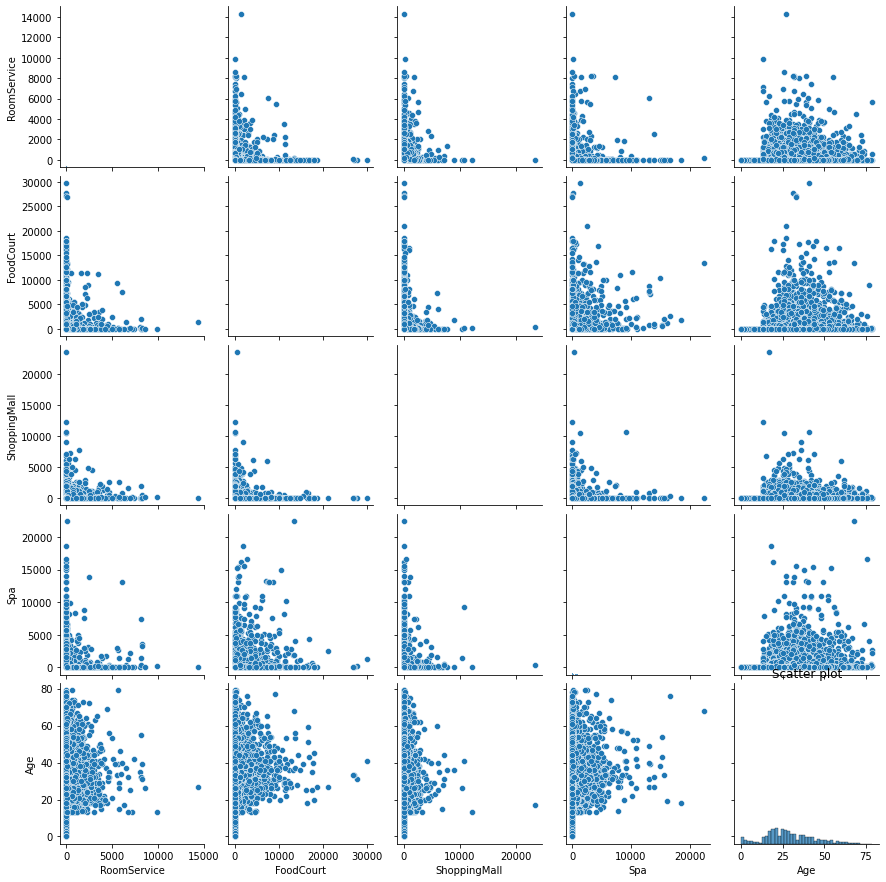

In [39]:
# numericial data들로 scatter plot
numericial = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'Age']]
sns.pairplot(numericial)
plt.title("Scatter plot")
plt.show()

### scatter plot 결과 numericial data간에 **linear한 관계는 없어보이고**, 전체적으로 데이터가 0의 비중이 높은 것으로 확인됨

In [28]:
# categorical data의 비율 확인
print(train['VIP'].value_counts(), '\n')
print(train['CryoSleep'].value_counts(), '\n')
print(train['Destination'].value_counts(), '\n')
print(train['HomePlanet'].value_counts())

False    8291
True      199
Name: VIP, dtype: int64 

False    5439
True     3037
Name: CryoSleep, dtype: int64 

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64 

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64


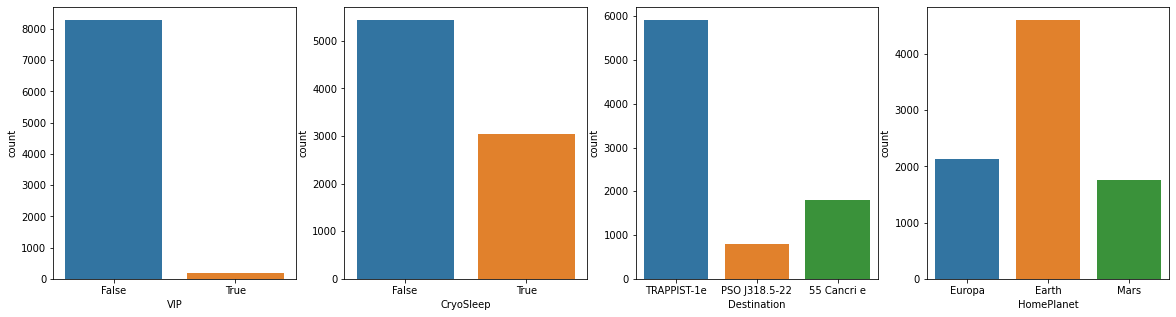

In [34]:
## countplot 
fig = plt.figure(figsize=(20, 5))

area1 = fig.add_subplot(1, 4, 1)
area2 = fig.add_subplot(1, 4, 2)
area3 = fig.add_subplot(1, 4, 3)
area4 = fig.add_subplot(1, 4, 4)

sns.countplot(x="VIP", data=train, ax=area1)
sns.countplot(x="CryoSleep", data=train, ax=area2)
sns.countplot(x="Destination", data=train, ax=area3)
sns.countplot(x="HomePlanet", data=train, ax=area4)
plt.show()

## Cabin 분석

In [170]:
def make_cabin(data:pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame()
    df.index = data.index
    df[['deck', 'num', 'side']] = None
    for idx, val in enumerate(data['Cabin'].values):
        if type(val) == float:
            continue
        deck, num, side = val.split('/')
        df.iloc[idx, :] = deck, num, side
    return df

In [171]:
train_cabin = make_cabin(train)

In [172]:
## deck, num, side 비율 확인
print(train_cabin['deck'].value_counts(), '\n')
print(train_cabin['num'].value_counts(), '\n')
print(train_cabin['side'].value_counts(), '\n')

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: deck, dtype: int64 

82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: num, Length: 1817, dtype: int64 

S    4288
P    4206
Name: side, dtype: int64 



In [246]:
train_cabin['Transported_True'] = train['Transported'].apply(lambda x: 1 if x else 0)
train_cabin['Transported_False'] = train['Transported'].apply(lambda x: 0 if x else 1)

In [250]:
train_cabin.groupby('side').sum()

,Transported,Transported_True,Transported_False
side,,,
P,1898,1898,2308
S,2380,2380,1908


# Preprocessing

## train에 cabin의 deck, side, num data 추가해주기

In [321]:
def preprocess(data:pd.DataFrame,impute_method="most_frequent", scaler_method="minmax", testset=False, selector=False) -> (X,Y):
    result = data.copy()
    # make cabin
    cabin = make_cabin(result)
    # one-hot & label encoding
    deck = pd.get_dummies(cabin['deck'])
    cabin['side'] = cabin['side'].apply(lambda x: 1 if x=="P" else 0)
    
    home = pd.get_dummies(result['HomePlanet'])
    dest = pd.get_dummies(result['Destination'])
    
    result['CryoSleep'] = result['CryoSleep'].apply(lambda x: 1 if x else 0)
    result['VIP'] = result['VIP'].apply(lambda x: 1 if x else 0)
    
    # concat
    result = pd.concat([result, home, dest, deck, cabin['side']], axis=1)
    # drop
    result.drop(columns=['HomePlanet', 'Destination', 'Cabin', 'PassengerId', 'Name'], inplace=True)
    
    # preprocessing
    impute = SimpleImputer(strategy=impute_method)
    scaler = MinMaxScaler()
        
    if not testset:
        Y = result['Transported'].apply(lambda x: 1 if x else 0)
        X = result.drop(columns="Transported")
        X = impute.fit_transform(X)
        X = scaler.fit_transform(X)
        return X, Y
    else:
        X = impute.fit_transform(result)
        X = scaler.fit_transform(X)
        return X

In [322]:
X_train, Y_train = preprocess(train)
X_test = preprocess(test, testset=True)

23

In [361]:
# select K feature
selector = SelectKBest(k=15)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

In [343]:
# gridsearch
params = {"learning_rate" : [0.05, 0.075, 0.1], 'subsample':[1, 0.75, 0.5], 'n_estimators':[100, 150, 200, 250, 300], 'max_depth':[2,3,4,5,6,7]}
model_boost = GradientBoostingClassifier()
grid_boost = GridSearchCV(model_boost, param_grid=params, cv=5, refit=True)
grid_boost.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.075, 0.1],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200, 250, 300],
                         'subsample': [1, 0.75, 0.5]})

In [296]:
scores = pd.DataFrame(grid_forest.cv_results_)
scores[['rank_test_score', 'mean_test_score', 'params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
80,1,0.791789,"{'max_depth': 7, 'min_samples_split': 3, 'n_es..."
82,2,0.791673,"{'max_depth': 7, 'min_samples_split': 3, 'n_es..."
77,3,0.790178,"{'max_depth': 7, 'min_samples_split': 2, 'n_es..."
85,4,0.789948,"{'max_depth': 7, 'min_samples_split': 4, 'n_es..."
87,5,0.789833,"{'max_depth': 7, 'min_samples_split': 4, 'n_es..."
...,...,...,...
7,86,0.737838,"{'max_depth': 2, 'min_samples_split': 3, 'n_es..."
2,87,0.737723,"{'max_depth': 2, 'min_samples_split': 2, 'n_es..."
13,88,0.737493,"{'max_depth': 2, 'min_samples_split': 4, 'n_es..."
10,89,0.737493,"{'max_depth': 2, 'min_samples_split': 4, 'n_es..."


In [344]:
scores = pd.DataFrame(grid_boost.cv_results_)
scores[['rank_test_score', 'mean_test_score', 'params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
35,1,0.801796,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est..."
133,2,0.801220,"{'learning_rate': 0.075, 'max_depth': 4, 'n_es..."
26,3,0.801106,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."
112,4,0.800991,"{'learning_rate': 0.075, 'max_depth': 3, 'n_es..."
197,5,0.800991,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
...,...,...,...
265,266,0.788681,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
268,267,0.788222,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
1,268,0.787648,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."
0,269,0.786383,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."


In [349]:
grid_boost.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.5}

In [358]:
best_boost = GradientBoostingClassifier(learning_rate=0.05,
                                       max_depth=4,
                                       n_estimators=150,
                                       subsample=0.5,
                                       random_state=10)

In [362]:
# best predictor로 예측
best_boost.fit(X_train_selected, Y_train)
pred = best_boost.predict(X_test_selected)
submission = pd.DataFrame(index=test.index)
submission['PassengerId'] = test['PassengerId']
submission['Transported'] = [[False, True][i] for i in pred]
submission.to_csv("submission.csv", index=False)

In [288]:
model_xgb = xgb.XGBClassifier()
model_svm = SVC()

In [364]:
#res_forest = cross_val_score(model_forest, X_train, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
res_boost = cross_val_score(best_boost, X_train_selected, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
#res_xgb = cross_val_score(model_xgb, X_train, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
#res_svm = cross_val_score(model_svm, X_train, Y_train, cv=10, scoring='accuracy', n_jobs=-1)

In [366]:
print(res_boost.mean())

0.7962780577490312


In [342]:
res_boost = cross_val_score(model_boost, X_train_selected, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(res_boost.mean())

0.796163512029946


In [290]:
print("Forest:", res_forest.mean(),'\n\n',"Boost:", res_boost.mean(),'\n\n',"XGB:", res_xgb.mean(), '\n\n',"SVM:", res_svm.mean(), '\n\n',"vote:", res_vote.mean())

Forest: 0.7905252437072604 

 Boost: 0.7985780987526949 

 XGB: 0.7952438395301774 

 SVM: 0.7868444373900505 

 vote: 0.8001887491237121


In [276]:
voting = VotingClassifier(estimators=[('Forest', model_forest), ('boost', model_boost),('svm', model_svm)], voting='soft')

In [277]:
res_vote = cross_val_score(voting, X_train, Y_train, cv=10, scoring='accuracy', n_jobs=-1)

In [282]:
voting.fit(X_train, Y_train)

VotingClassifier(estimators=[('Forest', RandomForestClassifier()),
                             ('boost', GradientBoostingClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')

In [283]:
voting.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1])

In [214]:
model_forest.fit(X_train, Y_train)
model_boost.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=10, n_estimators=300,
                           random_state=1)

In [ ]:
pred_forest = model_forest.predict(X_test)
pred_boost = model_boost.predict(X_test)

In [218]:
def make_submission(model, test_data:pd.DataFrame) -> None:
    submission = pd.DataFrame()
    pred = model.predict(test_data)
    submission['PassengerId'] = test['PassengerId']
    submission['Transported'] = [[False, True][i] for i in pred]
    submission.to_csv("submission2.csv", index=False)
    print("submission complete!!")

In [284]:
make_submission(voting, X_test)

submission complete!!


In [226]:
print(res_xgb)

[0.7954023  0.76896552 0.78045977 0.8009206  0.80437284 0.80897583
 0.82278481 0.81127733 0.80897583 0.79056387]


In [227]:
model_xgb.fit(X_train, Y_train)
make_submission(model_xgb, X_test)

submission complete!!


CryoSleep 0.15634278783062006
Age 0.07397386297500748
VIP 0.005213846185035436
RoomService 0.13600459065906143
FoodCourt 0.10487449066600035
ShoppingMall 0.08047589112859593
Spa 0.1530232803964911
VRDeck 0.12447100804628523
side 0.018441213255517362
Earth 0.053578599250629244
Europa 0.04845812949020751
Mars 0.01951918095986898
55 Cancri e 0.010923430002737879
PSO J318.5-22 0.005223145364850449
TRAPPIST-1e 0.009476543789091513


In [210]:
df = pd.read_csv("./submission.csv")

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0


In [89]:
temp_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0


In [ ]:
home = pd.get_dummies(train['HomePlanet'])
deck = pd.get_dummies(train['deck'])
dest = pd.get_dummies(train['Destination'])
train['CryoSleep'] = train['CryoSleep'].apply(lambda x: 1 if x else 0)
train['VIP'] = train['VIP'].apply(lambda x: 1 if x else 0)
train['side'] = train['side'].apply(lambda x: 1 if x=="P" else 0)
train = pd.concat([train, home, dest, deck], axis=1)
train.drop(columns=['HomePlanet', 'Destination', 'deck'], inplace=True)